In [45]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import time
from dataframes import CallCenter
import statsmodels.tsa.api as tsa
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,5
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as tsplt
from Tspredict import tseries

In [2]:
c = CallCenter()
c.cdf = c.dBtoDf()
ts= c.binnedType(c.cdf, 'Mobile Bestilling', "1D", "0:00", "23:00")

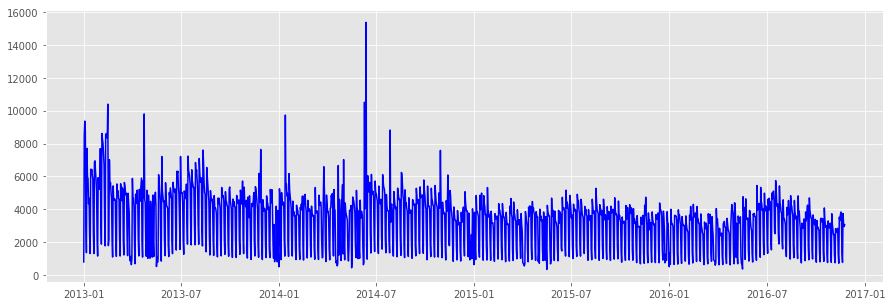

In [52]:
plt.plot(ts,color = 'b')

In [8]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7,center=False).mean()
    rolstd = timeseries.rolling(window=7,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.values[:,0], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

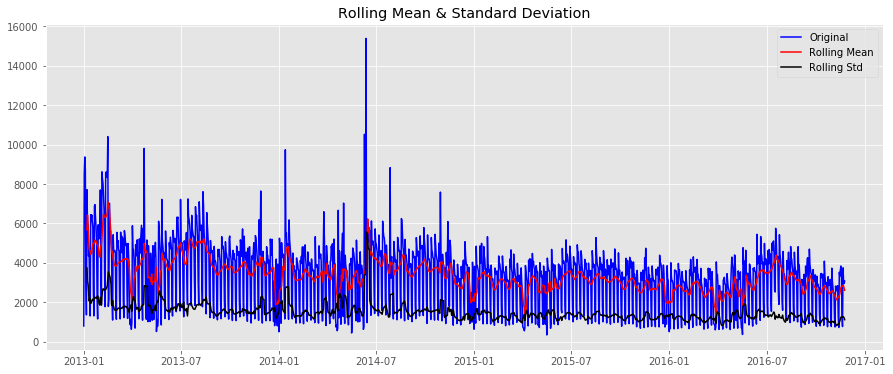

Results of Dickey-Fuller Test:
Test Statistic                   -3.746550
p-value                           0.003504
#Lags Used                       24.000000
Number of Observations Used    1399.000000
Critical Value (1%)              -3.435033
Critical Value (5%)              -2.863608
Critical Value (10%)             -2.567871
dtype: float64


In [9]:
test_stationarity(ts)

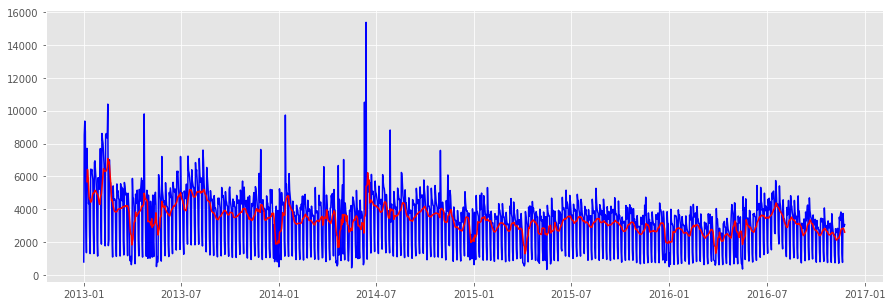

In [54]:
moving_avg = ts.rolling(window=7,center=False).mean()
plt.plot(ts,color = 'b')
plt.plot(moving_avg, color='r')

In [23]:
ts_moving_avg_diff = ts - moving_avg

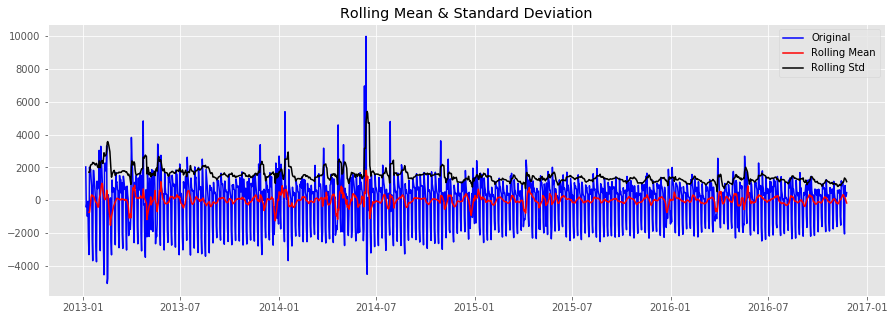

Results of Dickey-Fuller Test:
Test Statistic                -1.272001e+01
p-value                        9.873731e-24
#Lags Used                     2.300000e+01
Number of Observations Used    1.394000e+03
Critical Value (1%)           -3.435050e+00
Critical Value (5%)           -2.863616e+00
Critical Value (10%)          -2.567875e+00
dtype: float64


In [21]:
ts_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_moving_avg_diff)

In [24]:
ts_diff = ts - ts.shift()

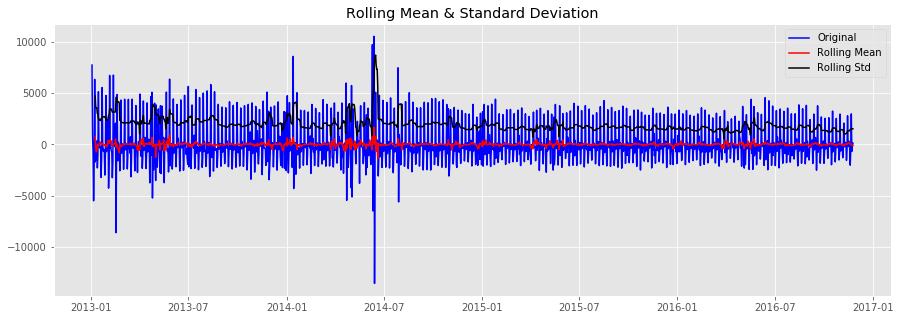

Results of Dickey-Fuller Test:
Test Statistic                -1.145549e+01
p-value                        5.720175e-21
#Lags Used                     2.300000e+01
Number of Observations Used    1.399000e+03
Critical Value (1%)           -3.435033e+00
Critical Value (5%)           -2.863608e+00
Critical Value (10%)          -2.567871e+00
dtype: float64


In [25]:
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

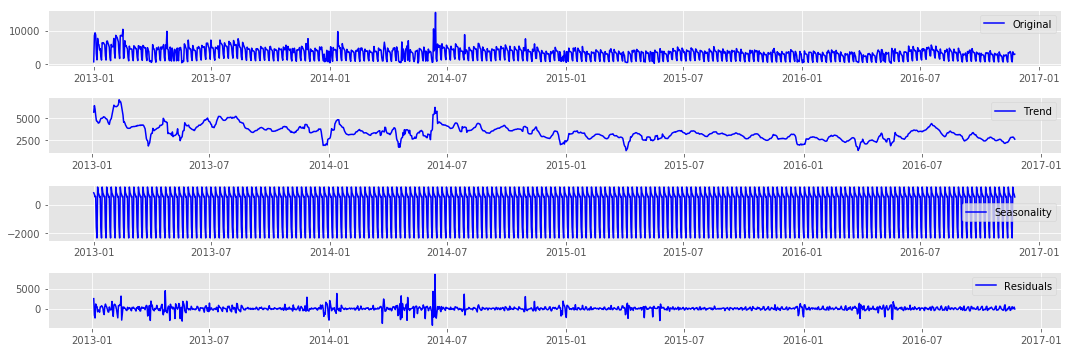

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original',color = 'b')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend',color = 'b')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality',color = 'b')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals',color = 'b')
plt.legend(loc='best')
plt.tight_layout()

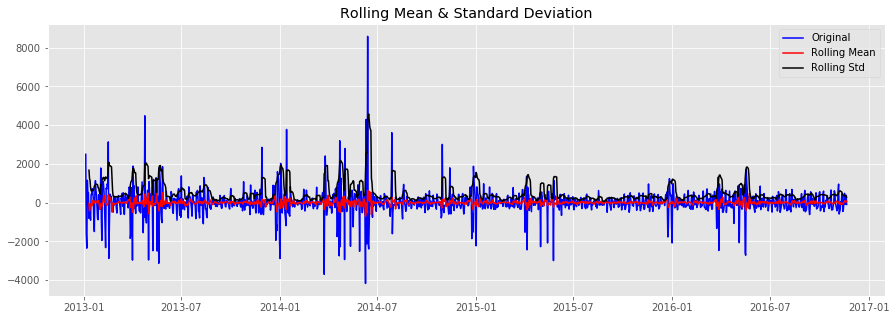

Results of Dickey-Fuller Test:
Test Statistic                -1.522261e+01
p-value                        5.458656e-28
#Lags Used                     2.200000e+01
Number of Observations Used    1.395000e+03
Critical Value (1%)           -3.435046e+00
Critical Value (5%)           -2.863614e+00
Critical Value (10%)          -2.567874e+00
dtype: float64


In [28]:
ts_decompose = residual
ts_decompose.dropna(inplace=True)
test_stationarity(ts_decompose)

In [29]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

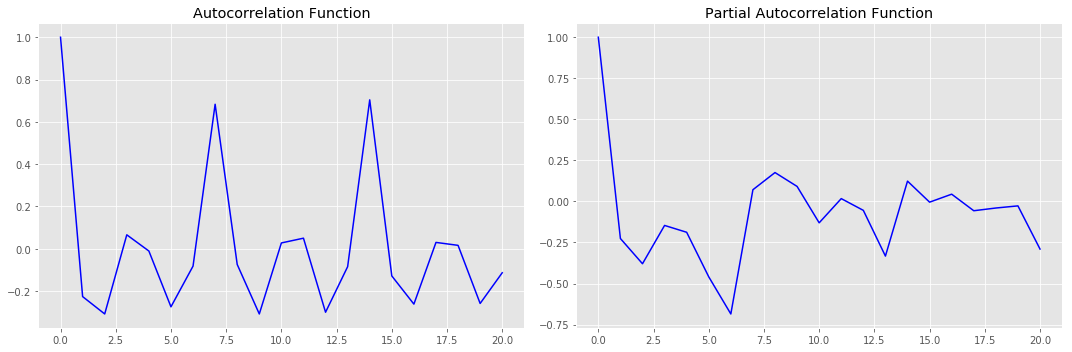

In [56]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf,color = 'b')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf,color = 'b')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

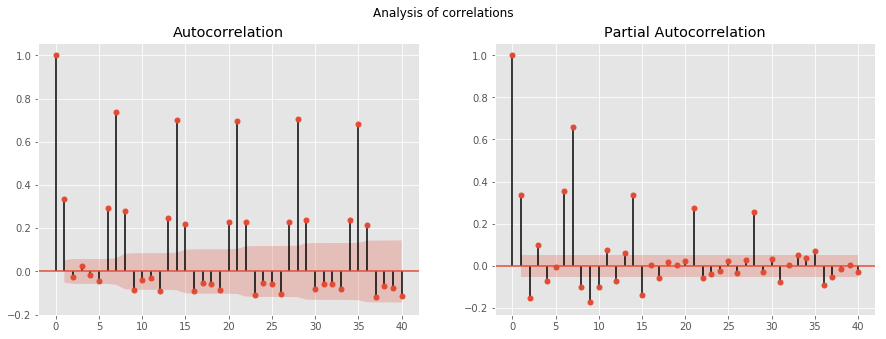

In [58]:
all_plots, axes = plt.subplots(1,2)
all_plots = tsplt.plot_acf(ts, lags=40, ax=axes[0])
all_plots = tsplt.plot_pacf(ts, lags=40, ax=axes[1])
plt.suptitle('Analysis of correlations')
plt.show()

In [ ]:
mod = tsa.statespace.SARIMAX(ts,order=(7,1,0),seasonal_order=(1,1,1,7),trend = 't')
res = mod.fit(disp=False)
print(res.summary())
# plot residual errors

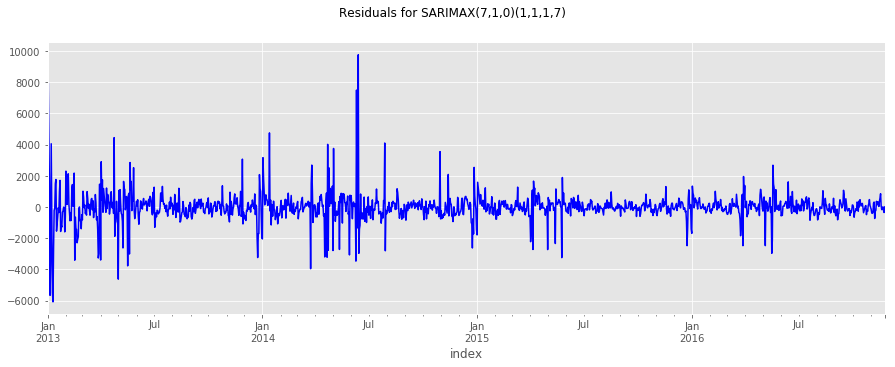

In [59]:
residuals = res.resid
residuals.plot(color = 'b')
plt.suptitle('Residuals for SARIMAX(7,1,0)(1,1,1,7)')

count    1424.000000
mean      -10.872109
std       930.019530
min     -6082.895876
25%      -298.953777
50%        -8.117257
75%       278.692895
max      9765.747846
dtype: float64


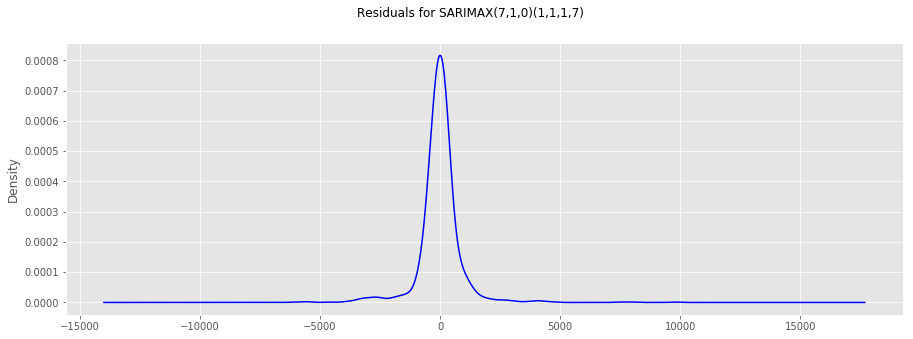

In [60]:
residuals.plot(kind='kde',color = 'b')
plt.suptitle('Residuals for SARIMAX(7,1,0)(1,1,1,7)')
print(residuals.describe())

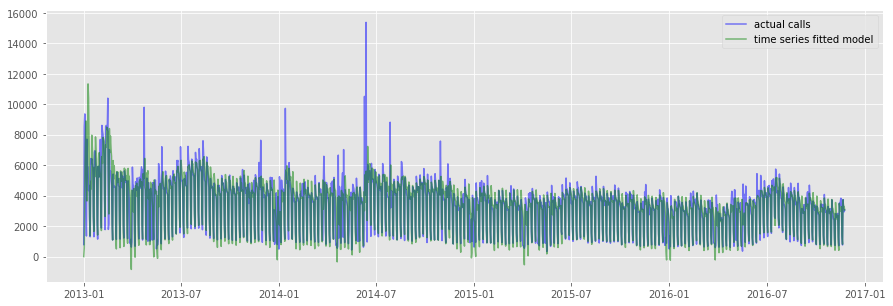

In [66]:
plt.plot(ts, 'b', label='actual calls', alpha=0.5)
plt.plot(res.fittedvalues, color='g', label='time series fitted model', alpha=0.5)
plt.legend()

In [47]:
pred = res.predict(end=len(ts)+14)

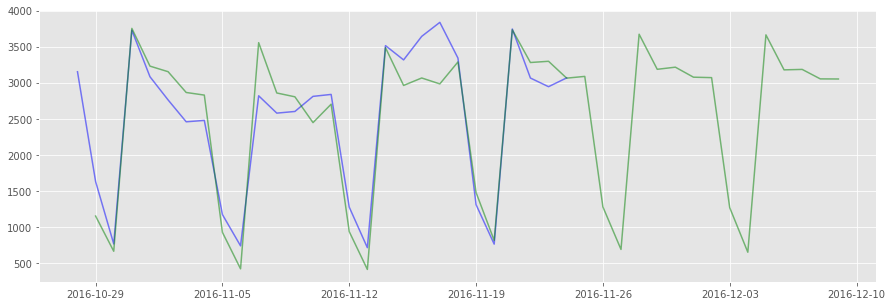

In [69]:
plt.plot(ts[-28:],color = 'b',alpha = 0.5,label='actual calls')
plt.plot(pred[-42:],color = 'g',alpha = 0.5,label='time series fitted model')